# Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# load data
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')


In [19]:
# Show index of duplicates
df_duplicate_analisys = df[df.duplicated(keep=False)]

def remove_dup(df: pd.DataFrame):
    # Now remove duplicates
    df = df.drop_duplicates()
    return df


In [20]:
# Value mapping

def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df


In [21]:
# Drop columns

def drop_columns(df: pd.DataFrame):
    df = df.drop(columns=['car'])
    #df = df.drop(columns=['toCoupon_GEQ5min'])
    df = df.drop(columns=['direction_opp'])
    return df

# Feature Engineering

## toCoupon_GEQ

In [22]:
# combine toCoupon_GEQ5min’, toCoupon_GEQ15min’ and ‘toCoupon_GEQ25min’ into one column 0, 1, 2 values

#0: driving distance is less than or equal to 15 min
#1: driving distance is greater than 15 min and less than or equal to 25 min
#2: driving distance is greater than 25 min

def combine_distance_columns(df):
    """
    Combine 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', and 'toCoupon_GEQ25min' 
    columns into a single column 'to_coupon'.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe
    
    Returns:
    - df (pd.DataFrame): The modified dataframe with the 'to_coupon' column
    """
    
    def assign_to_coupon(row):
        if row['toCoupon_GEQ25min'] == 1:
            return 2
        elif row['toCoupon_GEQ15min'] == 1:
            return 1
        else:
            return 0

    # add the new column at penultimate position (before 'Y')
    df.insert(len(df.columns) - 1, 'to_coupon', np.nan)
    df['to_coupon'] = df.apply(assign_to_coupon, axis=1)

    # Drop the original columns
    df.drop(['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'], axis=1, inplace=True)
    
    return df


- Removed duplicates
- Applied ordinal encoding to the obvious variables (i.e. Age, Income, Temperature, the 5 frequency variables)
- Dropped car
- to_Coupon_GEQ

In [23]:
df_test1 = df.copy()

df_test1 = remove_dup(df_test1)
df_test1 = value_mapping(df_test1)
df_test1 = drop_columns(df_test1)
df_test1 = combine_distance_columns(df_test1)

## Age taxonomy

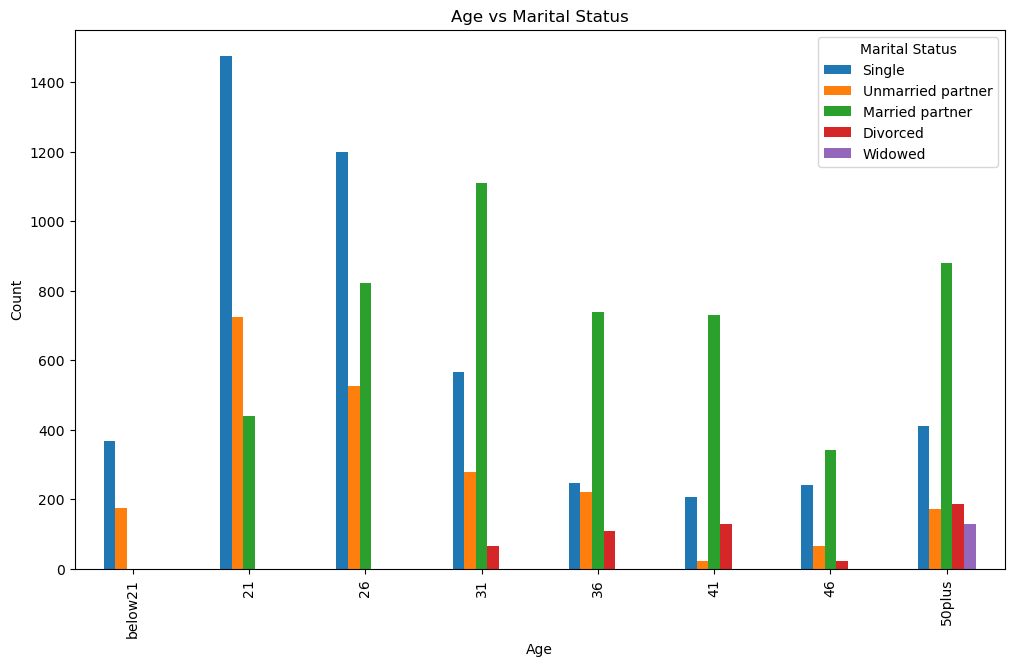

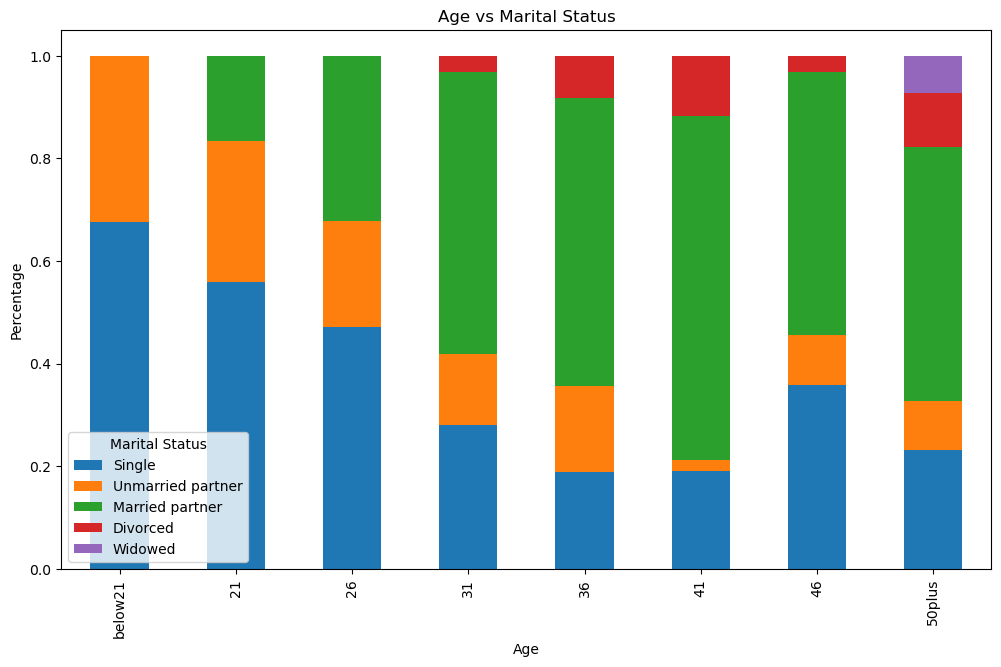

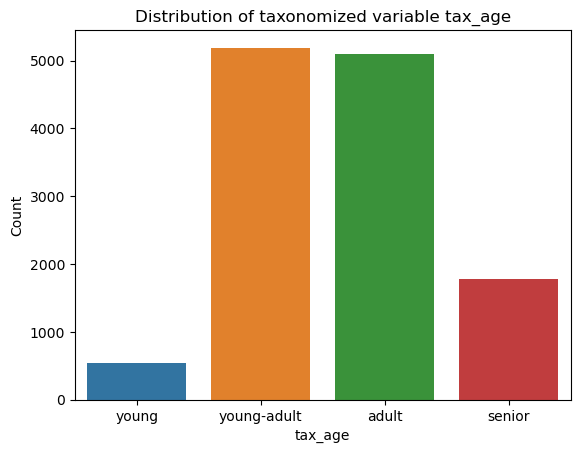

In [24]:
# analyzing age with the help of marital status

# defining 'age' categories order for visualization
custom_order_Age = [0, 1, 2, 3, 4, 5, 6, 7]

# defining 'maritalStatus' categories order for visualization
custom_order_MS = ['Single','Unmarried partner','Married partner','Divorced','Widowed']

# defining the x-axis legend
x_axis = ['below21', '21', '26', '31', '36', '41', '46', '50plus']

# pivoting the data to get counts of each combination
pivot_df = df_test1.groupby(['age', 'maritalStatus']).size().unstack().fillna(0)

# ordering the data based on the custom orders
pivot_df = pivot_df.reindex(custom_order_Age)[custom_order_MS]

# plotting grouped bar plot
pivot_df.plot(kind='bar', figsize=(12, 7), stacked=False)
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(custom_order_Age, x_axis)
plt.title('Age vs Marital Status')
plt.legend(title='Marital Status')
plt.show()


####################

# redoing this, but to analyze the percentage of each marital status per age group instead of raw counts
pivot_df = df_test1.groupby(['age', 'maritalStatus']).size().unstack().fillna(0)
pivot_df = pivot_df.reindex(custom_order_Age)[custom_order_MS]
pivot_df = pivot_df.apply(lambda x: x/x.sum(), axis=1)
pivot_df.plot(kind='bar', figsize=(12, 7), stacked=True)
plt.xlabel('Age')
plt.ylabel('Percentage')
plt.xticks(custom_order_Age, x_axis)
plt.title('Age vs Marital Status')
plt.legend(title='Marital Status')
plt.show()

# now, we create the new taxonomized variable 'tax_age'
# along the rules:
# 0: below 21         (0)                (young)
# 1: 21, 26           (1,2)              (young-adult)
# 2: 31, 36, 41, 46   (3,4,5,6)          (adult)
# 3: 50plus           (7)                (senior)

df_test1['tax_age'] = df_test1['age'].apply(lambda x: 0 if x == 0 else (1 if x in [1, 2] else (2 if x in [3, 4, 5, 6] else 3)))

# visualizing its distribution
sns.countplot(x='tax_age', data=df_test1)
plt.xlabel('tax_age')
plt.ylabel('Count')
plt.xticks([0, 1, 2, 3], ['young', 'young-adult', 'adult', 'senior'])
plt.title('Distribution of taxonomized variable tax_age')
plt.show()

## Coupon Importance

### First we create: Coupon total frequency

In [25]:
# {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}


# summing all this up
def create_coupon_freq_total(number_used_for_gt8, df):
    # first, we need to encode the 5 coupon variables: 'CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'Bar'
    # using the mean of each interval as the value to be encoded (what about for gt8?)

    coupon_names = ['CoffeeHouse', 'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50', 'Bar']
    for coupon_name in coupon_names:
        df['mean_' + coupon_name] = df[coupon_name].apply(lambda x: 0 if x == 0 else (1 if x == 1 else (2 if x == 2 else (6 if x == 3 else number_used_for_gt8))))

    # creating a new variable called coupon_freq_total which is the sum of all the coupon frequency variables
    coupon_freq_total = df['mean_CoffeeHouse'] + df['mean_CarryAway'] + df['mean_RestaurantLessThan20'] + df['mean_Restaurant20To50'] + df['mean_Bar']
    return coupon_freq_total


# creating a new variable called coupon_freq_total which is the sum of all the coupon frequency variables
number_used_for_gt8 = 9
df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)


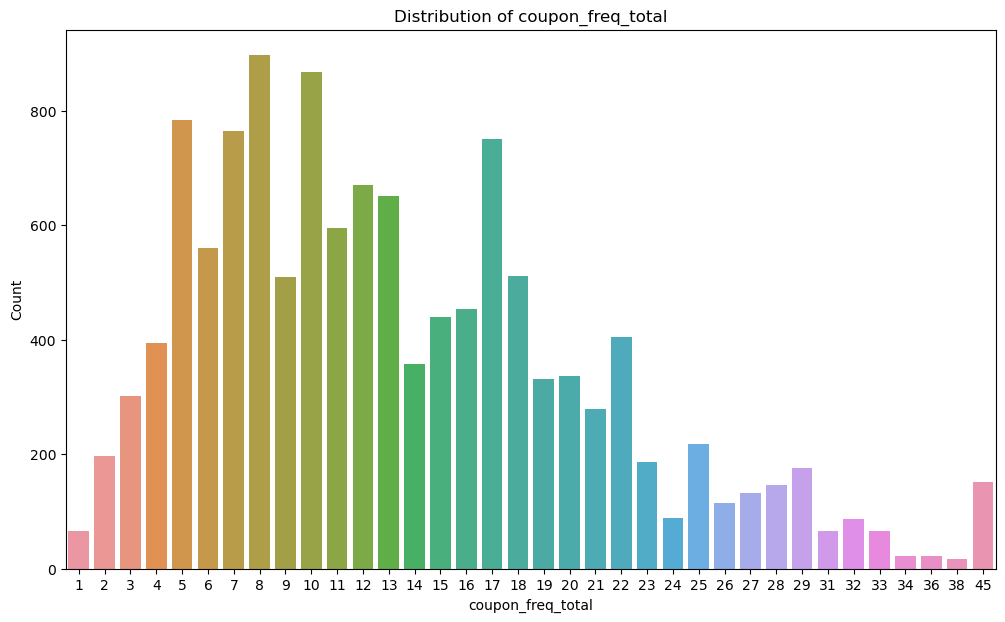

In [26]:
# checking the new variable coupon_freq_total

# value counts
#print(df_test1['coupon_freq_total'].value_counts())
# bar plot for bar distribution
plt.figure(figsize=(12, 7))
sns.countplot(x='coupon_freq_total', data=df_test1)
plt.xlabel('coupon_freq_total')
plt.ylabel('Count')
plt.title('Distribution of coupon_freq_total')
plt.show()

In [27]:
# does coupon_freq_total have 0s?
print('coupon_freq_total has', len(df_test1[df_test1['coupon_freq_total'] == 0]), '"0s".')

coupon_freq_total has 0 "0s".


Now, we will use this new variable to create the one we actually want: the importance of the given coupon for the given user. We will call this variable `coupon_importance`. 

Comes from dividing the coupon frequency by the total frequency of the user. E.g. if coupon = 'Bar', then coupon_importance = Bar_frequency / coupon_total_frequency.

In [28]:
# Vectorized computation of coupon_importance
def compute_importance(row):

    # Mapping coupon to respective frequency columns
    coupon_to_freq_mapping = {
        'Coffee House': 'mean_CoffeeHouse',
        'Carry out & Take away': 'mean_CarryAway',
        'Restaurant(<20)': 'mean_RestaurantLessThan20',
        'Restaurant(20-50)': 'mean_Restaurant20To50',
        'Bar': 'mean_Bar'
    }

    given_coupon = coupon_to_freq_mapping[row['coupon']]
    total_freq = row['coupon_freq_total']
    return row[given_coupon] / total_freq if total_freq else 0

df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)

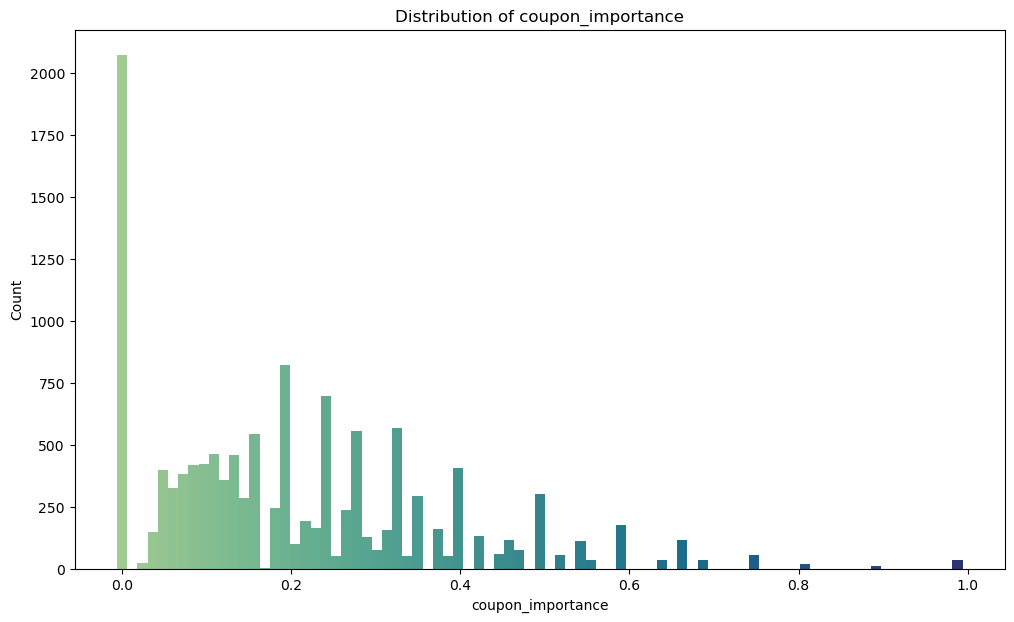

In [29]:
# visualizing new variable coupon_importance distribution

# determining unique values and the number of bins
bins = df_test1['coupon_importance'].nunique()
values, edges = np.histogram(df_test1['coupon_importance'], bins=bins)

colors = sns.color_palette("crest", bins)
plt.figure(figsize=(12, 7))
for i in range(bins):
    plt.bar(edges[i], values[i], width=edges[i+1]-edges[i], color=colors[i])
plt.xlabel('coupon_importance')
plt.ylabel('Count')
plt.title('Distribution of coupon_importance')
plt.show()

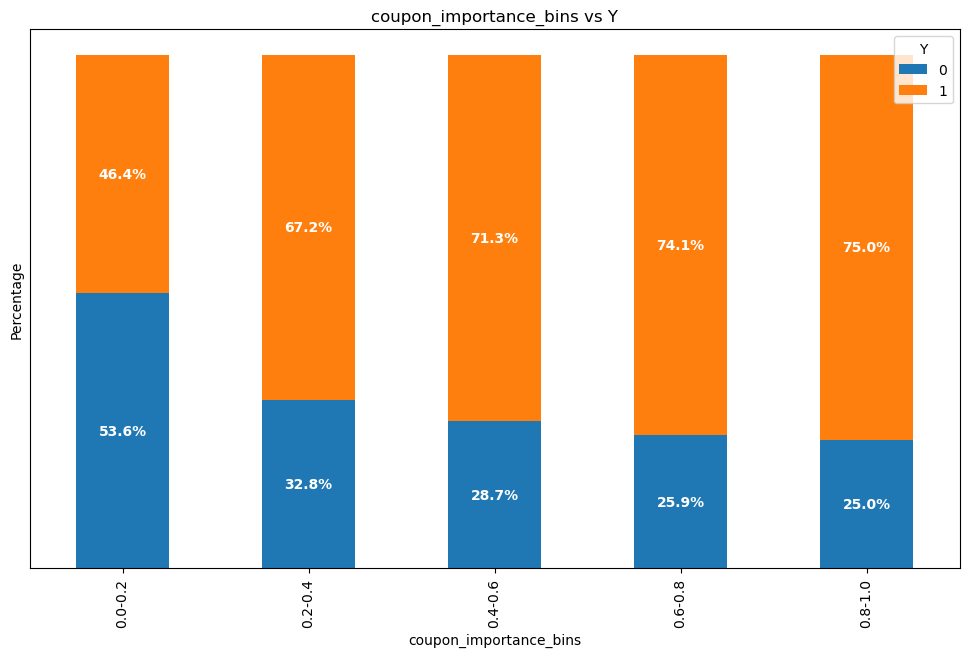

In [33]:
# creating a function to plot the percentage of each category of a feature vs the target variable
def feature_vs_target(df, feature, target, returnQ = False, plotQ = True):
    """
    Plots a bar plot of the percentage of each category of the feature vs the target variable.
    
    Parameters:
    - df (pd.DataFrame): The input dataframe
    - feature (str): The feature column name
    - target (str): The target column name
    
    Returns:
    - None
    """
    
    # Calculating counts for each category
    grouped = df.groupby([feature, target]).size().unstack(fill_value=0)

    # Calculating percentages
    grouped_percentage = grouped.divide(grouped.sum(axis=1), axis=0) * 100



    
    
    if returnQ == True:
        return grouped_percentage
    
    if plotQ == True:
        # Plotting
        ax = grouped_percentage.plot(kind='bar', stacked=True, figsize=(12,7))
        plt.title(feature + ' vs ' + target)
        plt.xlabel(feature)
        plt.ylabel('Percentage')
        plt.yticks([])  # Hide yticks

        # Display percentages on the bars
        for index, rect in enumerate(ax.patches):
            y_value = rect.get_height()
            x_value = rect.get_x() + rect.get_width() / 2

            # Choose the y-value based on the height of the bar segment
            vertical_position = rect.get_y() + y_value / 2

            label = "{:.1f}%".format(y_value)
            ax.annotate(label, (x_value, vertical_position), xytext=(0, 0),
                        textcoords="offset points", ha='center', va='center', color='white', weight='bold')        
        plt.show()


# binning coupon_importance
n_bins = 5
bins = np.arange(0, 1+1/n_bins, 1/n_bins)
labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]



df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)

# plotting coupon_importance_bins vs Y
feature_vs_target(df_test1, 'coupon_importance_bins', 'Y')

In [31]:
# this is where we searched for a nice value for number_used_for_gt8, 
# one that at least orders P(Y=1 | Coupon Importance) in ascending order

'''
number_used_for_gt8 = 9
values_that_work = []
while number_used_for_gt8 in range(9,100):

    df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)
    df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)
    # binning coupon_importance
    n_bins = 5
    bins = np.arange(0, 1+1/n_bins, 1/n_bins)
    labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]
    df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)
    # plotting coupon_importance_bins vs Y
    prob_data = feature_vs_target(df_test1, 'coupon_importance_bins', 'Y', returnQ=True, plotQ=False)

    # extracting only the Y=1 probabilities
    prob_data = prob_data[1]

    # checking if these probabilities are in ascending order
    if prob_data.is_monotonic_increasing:
        values_that_work.append(number_used_for_gt8)

    # printing at each 100th iteration
    if number_used_for_gt8 % 25 == 0:
        print('number_used_for_gt8 =', number_used_for_gt8, 'examined.')
    
    number_used_for_gt8 += 1
    

print('Values that work:', values_that_work)
'''

# With n_bins = 5
# range(9, 100)
# Values that work: [16, 17, 18]

"\nnumber_used_for_gt8 = 9\nvalues_that_work = []\nwhile number_used_for_gt8 in range(9,100):\n\n    df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)\n    df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)\n    # binning coupon_importance\n    n_bins = 5\n    bins = np.arange(0, 1+1/n_bins, 1/n_bins)\n    labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]\n    df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)\n    # plotting coupon_importance_bins vs Y\n    prob_data = feature_vs_target(df_test1, 'coupon_importance_bins', 'Y', returnQ=True, plotQ=False)\n\n    # extracting only the Y=1 probabilities\n    prob_data = prob_data[1]\n\n    # checking if these probabilities are in ascending order\n    if prob_data.is_monotonic_increasing:\n        values_that_work.append(number_used_for_gt8)\n\n    # printing at e

Is the probability of Y=1 in ascending order? True


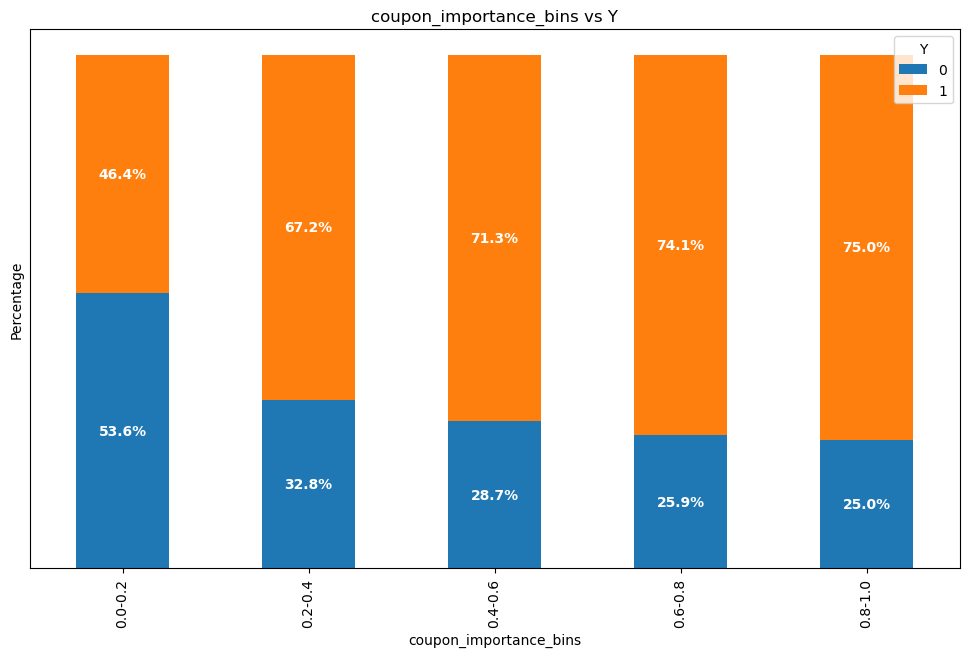

In [32]:
# testing with number_used_for_gt8 = 16 and n_bins = 5

number_used_for_gt8 = 16
df_test1['coupon_freq_total'] = create_coupon_freq_total(number_used_for_gt8, df_test1)
df_test1['coupon_importance'] = df_test1.apply(compute_importance, axis=1)
# binning coupon_importance
n_bins = 5
bins = np.arange(0, 1+1/n_bins, 1/n_bins)
labels = [str(round(float(bins[i]), 3)) + '-' + str(round(float(bins[i+1]), 3)) for i in range(n_bins)]
df_test1['coupon_importance_bins'] = pd.cut(df_test1['coupon_importance'], bins=bins, labels=labels, right=False)
# plotting coupon_importance_bins vs Y
prob_data = feature_vs_target(df_test1, 'coupon_importance_bins', 'Y', returnQ=True)

# extracting only the Y=1 probabilities
prob_data = prob_data[1]

# checking if these probabilities are in ascending order
print('Is the probability of Y=1 in ascending order?', prob_data.is_monotonic_increasing)

feature_vs_target(df_test1, 'coupon_importance_bins', 'Y')